# Hack@CEWIT 2019

In [1]:
import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.utils
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from os import listdir
from os.path import isfile, join
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

Using TensorFlow backend.


### Get file names

In [2]:
# 路径前缀
path_parasitized, path_uninfected = './cell_images/final_p/', './cell_images/final_u/'
# 包含文件名的list
files_parasitized = [f for f in listdir(path_parasitized) if isfile(join(path_parasitized, f))]
files_uninfected = [f for f in listdir(path_uninfected) if isfile(join(path_uninfected, f))]
if '.DS_Store' in files_parasitized:
    files_parasitized.remove('.DS_Store')
if '.DS_Store' in files_uninfected:
    files_uninfected.remove('.DS_Store')
print(len(files_parasitized), ' parasitized records\n', len(files_uninfected), ' uninfected records', sep='')

5415 parasitized records
5924 uninfected records


### Load all image file to DataFrame

In [3]:
def loadData(prefix, names, classification):
    pixels = []
    for i in range(len(names)):
        im = Image.open(prefix + names[i])#.convert('L')
        pix = np.asarray(im)
        pixels.append(pix)
    df_temp = pd.DataFrame({'Name': names, 'Image': pixels})
    df_temp['Classification'] = classification
    return df_temp

df_parasitize = loadData(path_parasitized, files_parasitized, 1)
df_uninfected = loadData(path_uninfected, files_uninfected, 0)

In [4]:
data = pd.concat([df_parasitize, df_uninfected])
data = sklearn.utils.shuffle(data)
data = data.reset_index(drop=True)

In [5]:
data.head(5)

,Name,Image,Classification
0,4633.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1,3939.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,3284.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
3,2584.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
4,4639.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0


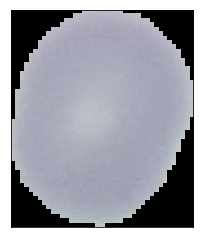

In [6]:
fig = plt.figure()
plt.imshow(data.Image.values[1], cmap='gray', interpolation='none')
plt.xticks([]); plt.yticks([])
plt.show()

---

In [7]:
default_img_size, total_data = 150, data.shape[0]
print('default_img_size: ', default_img_size, '\ntotal_data: ', total_data, sep='')

default_img_size: 150
total_data: 11339


#### Split Data Into Train And Test

In [8]:
epochs, train_percentage = 10, 0.75
num_train_data = int(total_data * train_percentage)
num_test_data = total_data - num_train_data

In [9]:
data_train, data_test = data[:num_train_data], data[num_train_data:]
X_train, y_train = data_train.Image.values, data_train.Classification.values
X_test, y_test = data_test.Image.values, data_test.Classification.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(8504,)
(8504,)
(2835,)
(2835,)


### Resize Image

In [10]:
def resize(original):
    length = len(original)
    pixels = np.zeros((length, default_img_size, default_img_size, 3), dtype=np.uint8)
    for i in range(length):
        pix = original[i]
        j, k, l = pix.shape
        resized = np.zeros((default_img_size, default_img_size, 3))
        resized[:j, :k, :l] = pix
        pixels[i] = resized
    return pixels

X_train = resize(X_train)
X_test = resize(X_test)
print(X_train.shape, X_test.shape, sep='\n')

(8504, 150, 150, 3)
(2835, 150, 150, 3)
(8504, 150, 150, 3)
(2835, 150, 150, 3)


### Build Model

In [11]:
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

In [12]:
print("Shape before one-hot encoding: ", y_train.shape, y_test.shape)
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)
print("Shape after one-hot encoding: ", y_train.shape, y_test.shape)

Shape before one-hot encoding:  (8504,) (2835,)
Shape after one-hot encoding:  (8504, 2) (2835, 2)


# Machine Learning

In [14]:
batch_size = 1
epoch = 1

In [15]:
model = Sequential([
    Conv2D(32, (5, 5), input_shape=(default_img_size,default_img_size, 3), activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.45),
    Dense(2, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
opt = Adam(lr=1e-5, decay=1e-5 / epoch)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

bestAcc = -1

best_path, load_old_model = 'bestmodel1.h5', True
if os.path.exists(best_path) and load_old_model:
    model.load_weights(best_path)
    print('Loaded')

Loaded


Epoch: 0
Epoch 1/1
8504/8504 [==============================] - 261s 31ms/step - loss: 0.1641 - acc: 0.9447


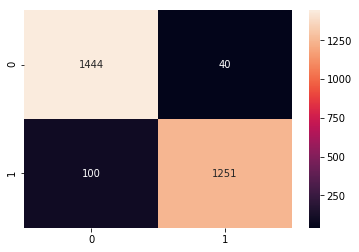

Test Accuracy: 0.9506172839506173
Epoch: 1
Epoch 1/1
8504/8504 [==============================] - 268s 32ms/step - loss: 0.1360 - acc: 0.9506


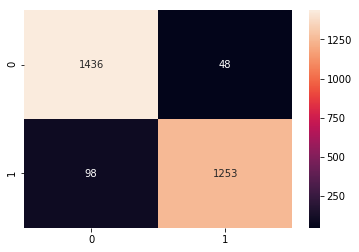

Test Accuracy: 0.9485008818342152
Epoch: 2
Epoch 1/1
8504/8504 [==============================] - 236s 28ms/step - loss: 0.1281 - acc: 0.9547


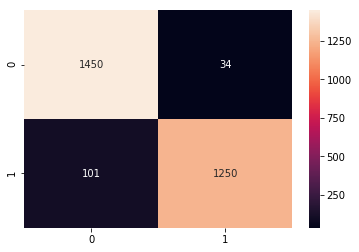

Test Accuracy: 0.9523809523809523
Epoch: 3
Epoch 1/1
8504/8504 [==============================] - 263s 31ms/step - loss: 0.1110 - acc: 0.9618


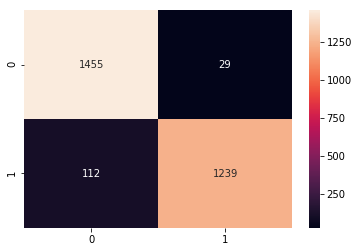

Test Accuracy: 0.9502645502645503
Epoch: 4
Epoch 1/1
8504/8504 [==============================] - 259s 30ms/step - loss: 0.1061 - acc: 0.9645


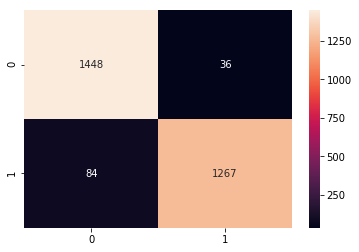

Test Accuracy: 0.9576719576719577
Epoch: 5
Epoch 1/1
8504/8504 [==============================] - 270s 32ms/step - loss: 0.1007 - acc: 0.9659


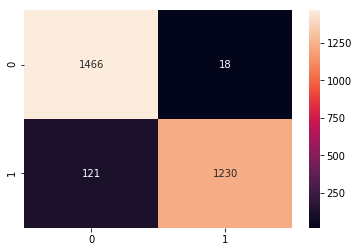

Test Accuracy: 0.9509700176366843
Epoch: 6
Epoch 1/1
8504/8504 [==============================] - 275s 32ms/step - loss: 0.0948 - acc: 0.9675


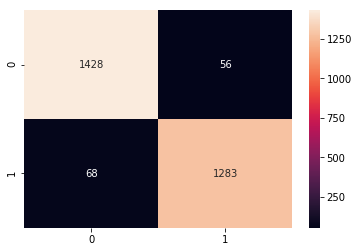

Test Accuracy: 0.9562610229276896
Epoch: 7
Epoch 1/1
8504/8504 [==============================] - 261s 31ms/step - loss: 0.0855 - acc: 0.9715


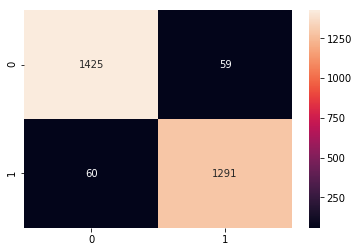

Test Accuracy: 0.9580246913580247
Epoch: 8
Epoch 1/1
8504/8504 [==============================] - 239s 28ms/step - loss: 0.0804 - acc: 0.9741


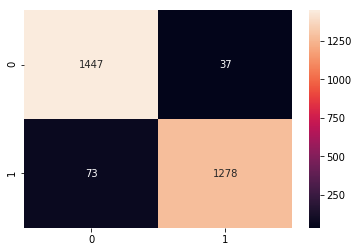

Test Accuracy: 0.9611992945326279
Epoch: 9
Epoch 1/1
8504/8504 [==============================] - 272s 32ms/step - loss: 0.0763 - acc: 0.9740


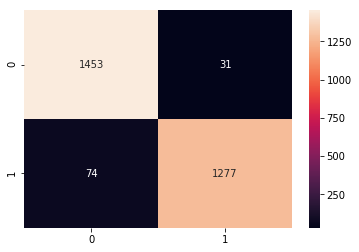

Test Accuracy: 0.9629629629629629


In [18]:
save_path = 'bestmodel2.h5'

for i in range(10):
    print('Epoch:', i)
    hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=1, verbose=1, shuffle=True)
    model_predicted = model.predict(X_test)
    cm = confusion_matrix(y_test.argmax(axis=1), model_predicted.argmax(axis=1))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.show()
    acc = (cm[0][0] + cm[1][1]) / num_test_data
    print('Test Accuracy:', acc)
    if bestAcc < acc:
        model.save_weights(save_path)